# Analysis for Zeisel's 3005 mouse brain cells

Aftering obtaining a transcript compatibility count (TCC) distribution matrix by running the pipeline, we use the matrix to:

1. <a href='#section1'> Cluster cells </a>
2. <a href='#section2'> Determine the accuracy of clustering </a>
3. <a href='#section3'> Analyze Zeisel et al.'s Oligo1 cells </a>
4. <a href='#section4'> Take a closer look at Zeisel et al.'s Oligo3 cells </a>
5. <a href='#section5'> Analyze accuracy of clustering as the number of reads decreases </a>

We will show how we accomplish each of these below.

For the following analysis, we load in the obtained TCC pairwise distance matrix (3005-by-3005 matrix) and sets of labels from the authors (271-by-1 vectors).

In [26]:
import pickle
import numpy as np
with open('Zeisel_TCC_pairwise_JS_distance_subsample100_full.dat','rb') as infile:
    D = pickle.load(infile)
    
# Zeisel's 9 main clusters
labels9 = np.loadtxt('./Zeisels_data/Zeisels_labels9.txt',dtype=str).astype(int)-1

# Zeisel's neurons (labeled as 0) and non-neurons (labeled as 1) obtained from labels9
labels2 = np.copy(labels9)
for i in [0,1,2]: labels2[labels2 == i] = 0
labels2[labels2 != 0] = 1

# Zeisel's 47 total clusters
labels47 = np.loadtxt('./Zeisels_data/Zeisels_labels47.txt',dtype=str)

## Clustering  <a id='section1'></a>

Clustering was performed using both spectral clustering (when the number of clusters is known) and affinity propagation (when the number of clusters is unknown). First, a low-dimensional embedding of the data is obtained using the precomputed distances and t-SNE:

In [2]:
%%time
from sklearn import manifold
def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=2000, verbose=1);
    X_tsne = tsne.fit_transform(D);
    return X_tsne
X_tsne = tSNE_pairwise(D)

[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.082504
[t-SNE] Error after 65 iterations with early exaggeration: 22.858847
[t-SNE] Error after 141 iterations: 2.182714
CPU times: user 1min 23s, sys: 8.62 s, total: 1min 31s
Wall time: 1min 31s


We first visualize the data using t-SNE and the authors' 9 labels.

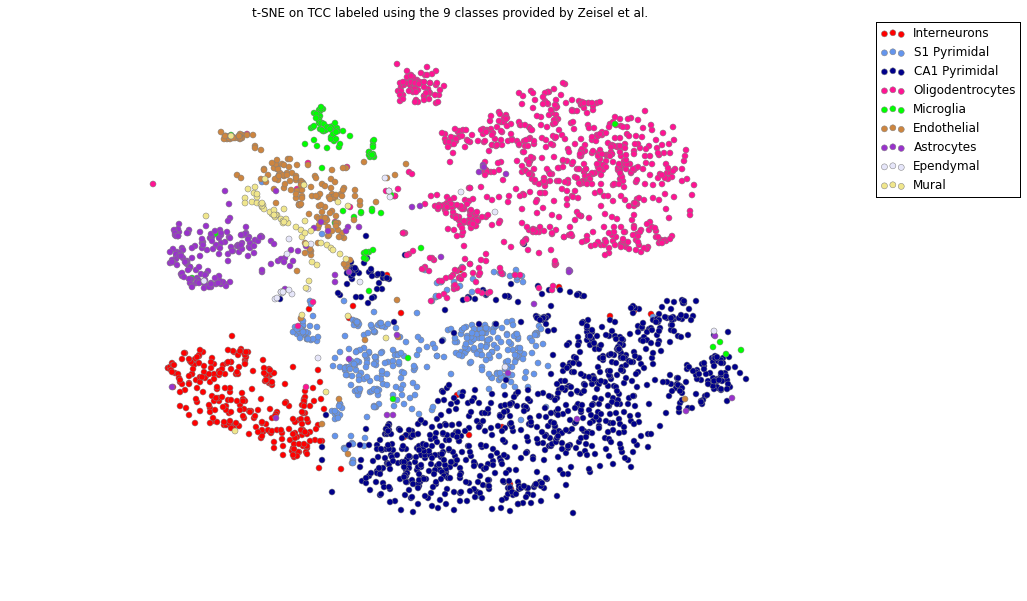

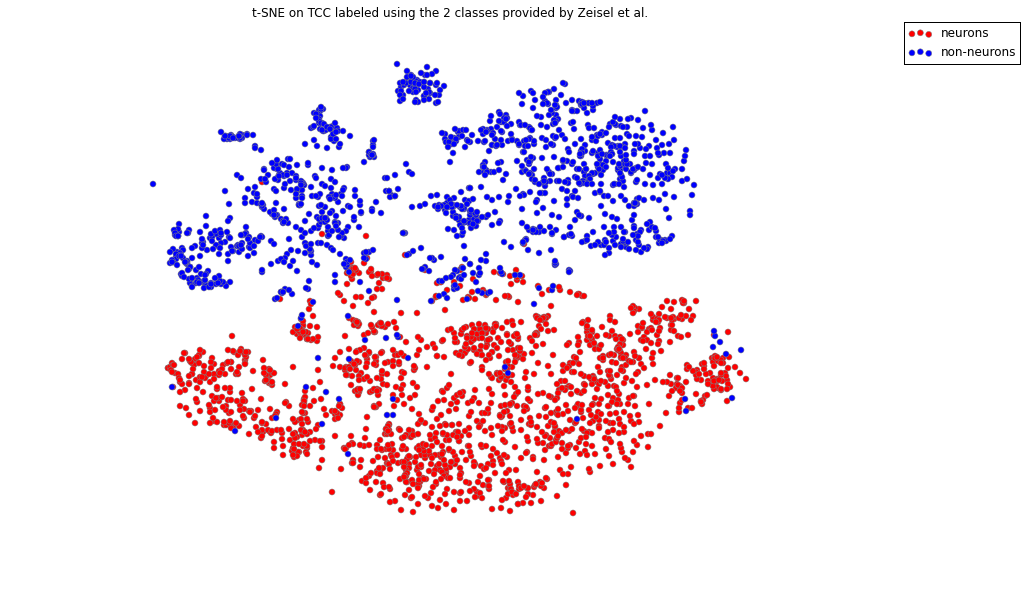

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt
# Plot function with Zeisel's colors corresponding to labels 
def tru_plot9(X,labels,t,clust_names,clust_color):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for i in unique_labels:
        ind = np.squeeze(labels == i)
        plt.scatter(X[ind,0],X[ind,1],c=clust_color[i],s=36,edgecolors='gray',
                    lw = 0.5, label=clust_names[i])        
    plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1))
    plt.legend(loc='upper right',bbox_to_anchor=(1.19, 1.01))
    plt.title(t)
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.axis('off')
    
tru_plot9(X_tsne,labels9,
         't-SNE on TCC labeled using the 9 classes provided by Zeisel et al.',
         clust_names = ['Interneurons','S1 Pyrimidal','CA1 Pyrimidal','Oligodentrocytes',
                   'Microglia','Endothelial','Astrocytes','Ependymal','Mural'],
         clust_color = ['red','cornflowerblue','darkblue','deeppink','lime',
                   'peru','darkorchid','lavender','khaki'])
tru_plot9(X_tsne,labels2,
         't-SNE on TCC labeled using the 2 classes provided by Zeisel et al.',
         clust_names = ['neurons','non-neurons'],
         clust_color = ['red','blue'])

Next, we cluster the cells using several approaches: spectral clustering for both k = 9 and k = 47, and affinity propagation with various parameters. We note here that spectral clustering can generate different results in different runs due to randomness. 

In [32]:
from sklearn import cluster

# obtain labels via spectral clustering
def spectral(k,D):
    if D[1,1] < 1: D = 1-D # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

tcc_spectral_labels2 = spectral(2,D)
tcc_spectral_labels9 = spectral(9,D)
tcc_spectral_labels47 = spectral(47,D)

# obtain labels via affinity propagation
def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

pref = -np.median(D.flatten())*np.ones(3005)
tcc_affinity_labels1 = AffinityProp(-D,pref,0.5)
tcc_affinity_labels2 = AffinityProp(-D,2*pref,0.7)

Converged after 28 iterations.
Converged after 32 iterations.


## Clustering Accuracy  <a id='section2'></a>

To determine the accuracy of clustering, we match the obtained cluster labels to Zeisel's labels. Because Zeisel et al. both created the dataset and were the ones to carefully craft methods for analyzing the data, we take their labels to be truth for now. 

Given a set of truth labels, we measure the accuracy of another set of labels using the [Kuhn Munkres max-weight matching algorithm](https://en.wikipedia.org/wiki/Hungarian_algorithm). We scale the output of this algorithm such that we get an error rate. After matching the labels, we output the proportion of cells that are still incorrectly labeled. 

In [53]:
import networkx as nx
import itertools

# gets max weight matching of a biparetite graph with row_label x column_label
# (weights are given by weight_matrix)
def get_max_wt_matching(row_label,column_label, weight_matrix):
    # Create a bipartite graph where each group has |unique labels| nodes 
    G = nx.complete_bipartite_graph(len(row_label), len(column_label))
    # Weight each edge by the weight in weight matrix.. 
    for u,v in G.edges(): G[u][v]["weight"]=weight_matrix[u,v-len(row_label)]
    # Perform weight matching using Kuhn Munkres
    H=nx.max_weight_matching(G)
    max_wt=0
    for u,v in H.items(): max_wt+=G[u][v]["weight"]/float(2)
    return max_wt

def compute_labeling_accuracy(label1, label2):
    uniq1,uniq2 = np.unique(label1),np.unique(label2)
    # Create two dictionaries. Each will store the indices of each label
    entries1,entries2 = {},{}
    for label in uniq1: entries1[label] = set(np.flatnonzero((label1==label)))
    for label in uniq2: entries2[label] = set(np.flatnonzero((label2==label)))
    # Create an intersection matrix which counts the number of entries that overlap for each label combination        
    W = np.zeros((len(uniq1),len(uniq2)))
    for i,j in itertools.product(range(len(uniq1)),range(len(uniq2))):
        W[i,j]=len(entries1[uniq1[i]].intersection(entries2[uniq2[j]]))
    # find the max weight matching
    match_val = get_max_wt_matching(uniq1,uniq2,W)
    # return the error rate
    return (1-match_val/float(len(label1)))*100

c2 = compute_labeling_accuracy(tcc_spectral_labels2,labels2)
print 'Spectral clustering with TCCs achieved an error rate of ' + str(c2) + '% (2 labels).'
c9 = compute_labeling_accuracy(tcc_spectral_labels9,labels9)
print 'Spectral clustering with TCCs achieved an error rate of ' + str(c9) + '% (9 labels).'

Spectral clustering with TCCs achieved an error rate of 2.59567387687% (2 labels).
Spectral clustering with TCCs achieved an error rate of 38.7021630616% (9 labels).


## Oligo1  <a id='section3'></a>

One of the Zeisel's findings with this 3005 mouse brain cell dataset was Oligo1, a previously unknown post-mitotic oligodendrocyte sub-class. Of the 3005 cells, only 45 were labeled as Oligo1 by the authors. 

The analysis below shows how in the case of the total number of clusters not being known, the Oligo1 subclass can still be identified using the TCC matrix. Specifically, cluster 22 from affinity propagation consisted almost exclusively of Oligo1 cells. We first visualize this:

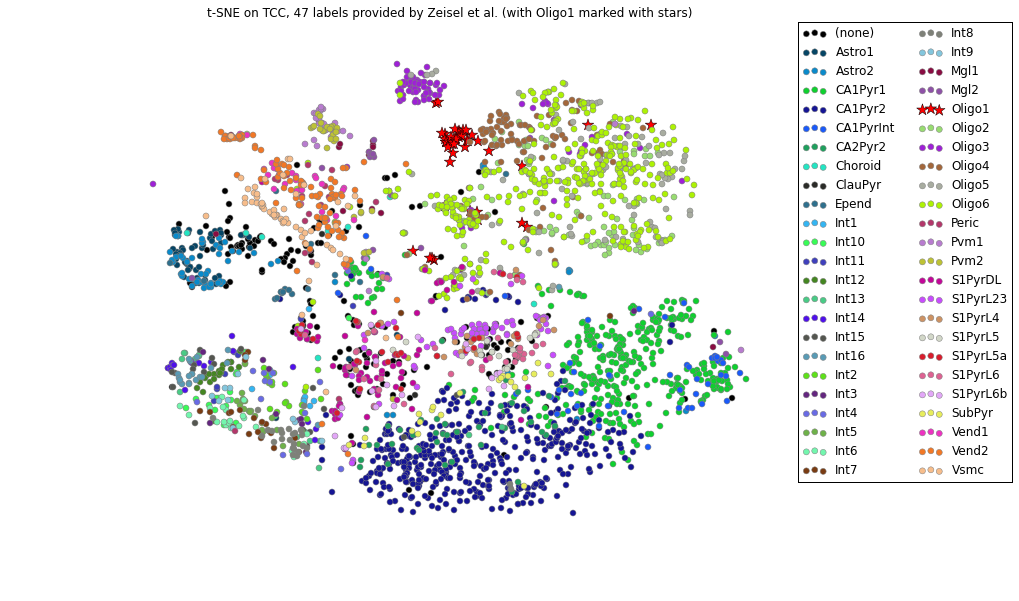

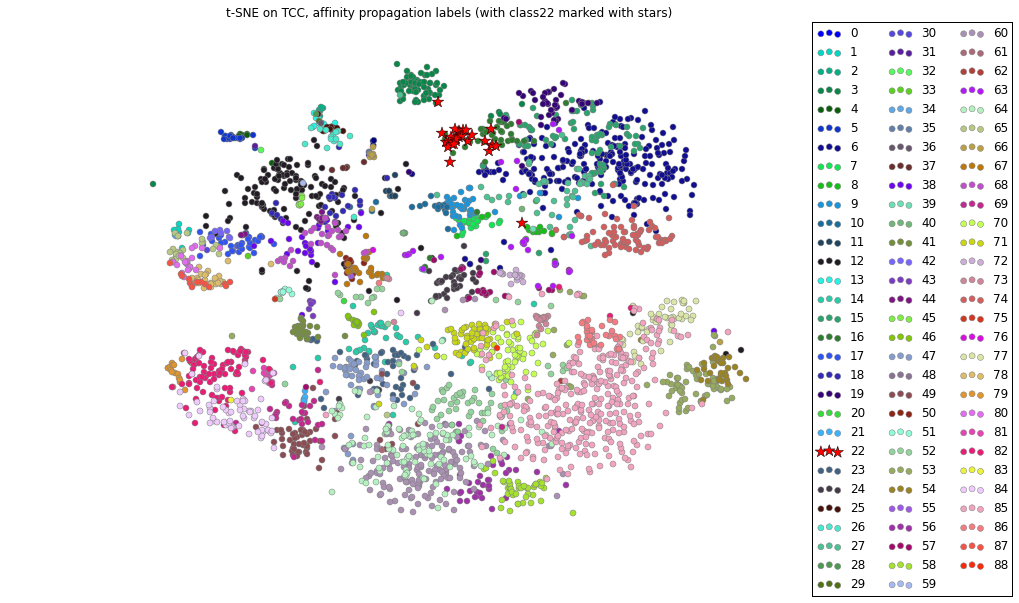

In [55]:
# Plot function with (nonrandom) colors corresponding to labels (star a specific label)
def stain_plot(X,labels,stain,title,nc=2):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), 
             int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=146,edgecolors='black',
                        lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolors='gray',
                        lw = 0.5,label=label)        
        i+=1   
    plt.title(title)
    plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=nc)
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.axis('off')

stain_plot(X_tsne,labels47,['Oligo1'],
           't-SNE on TCC, 47 labels provided by Zeisel et al. (with Oligo1 marked with stars)')
stain_plot(X_tsne,tcc_affinity_labels1,[22],
           't-SNE on TCC, affinity propagation labels (with class22 marked with stars)',3)

Next, we compare the expression of Oligo1 genes of the cells within cluster 22 to the expression of the samae genes of the cells in Zeisel et al.'s Oligo1 group. We see that the bars are very similar (24 of the 28 cells in cluster 22 were in Zeisel's Oligo1 group).

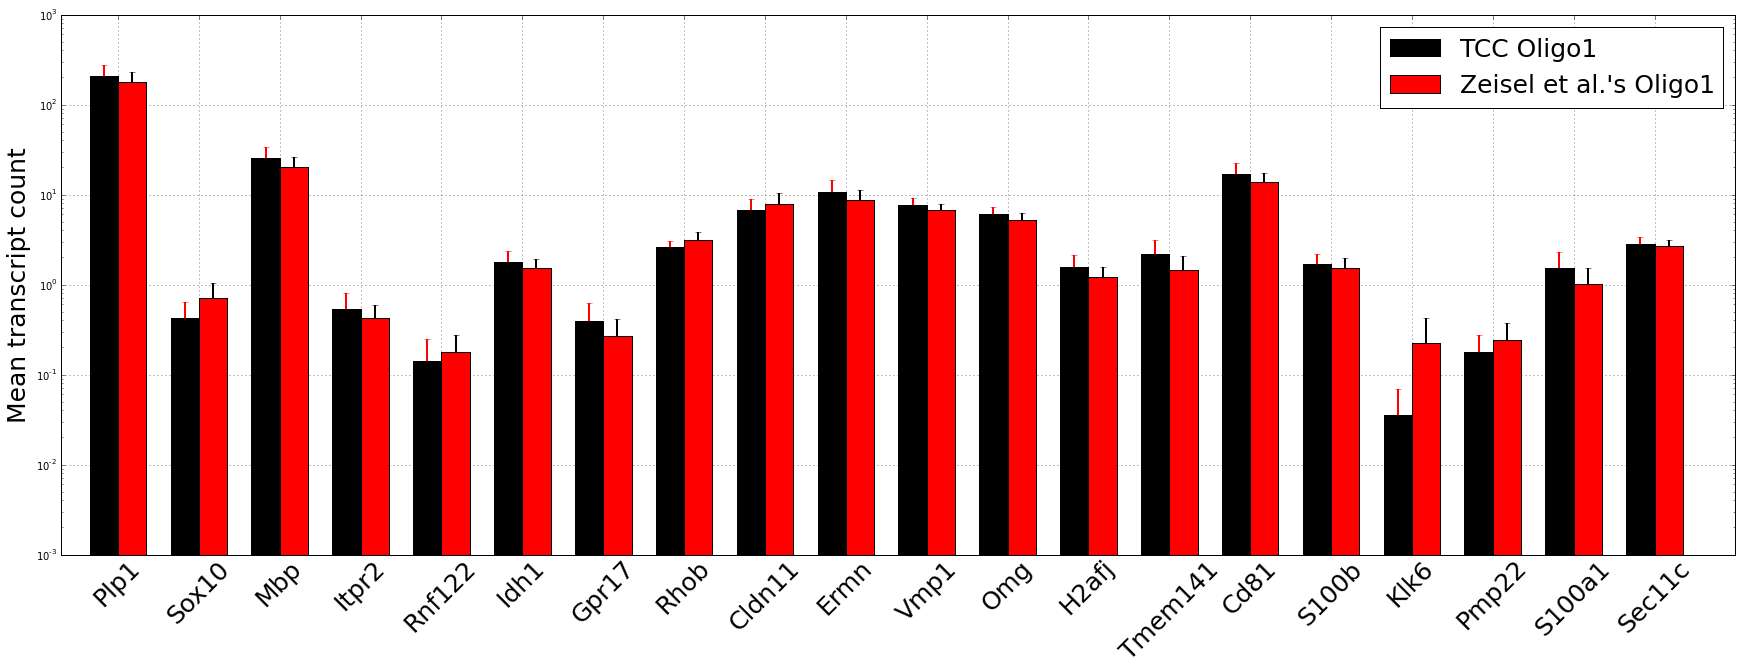

In [80]:
%matplotlib inline

# Compute means and std deviations of the Oligo1 genes
oligo1_markers = ["Plp1", "Sox10", "Mbp", "Itpr2", "Rnf122", "Idh1", 
                  "Gpr17", "Rhob", "Cldn11","Ermn","Vmp1", "Omg", "H2afj", 
                  "Tmem141", "Cd81", "S100b", "Klk6", "Pmp22", "S100a1", "Sec11c"]
c22_means,zo1_means,c22_std,zo1_std = [],[],[],[]
n_c22 = np.sum(tcc_spectral_labels47 == 22)
n_zo1 = np.sum(labels47 == 'Oligo1')
for gn in oligo1_markers:
    g = np.loadtxt('./Zeisels_data/'+gn+'_counts.txt')
    c22_means.append(np.mean(g[tcc_affinity_labels1 == 22]))
    zo1_means.append(np.mean(g[labels47 == 'Oligo1']))
    c22_std.append(np.std(g[tcc_affinity_labels1 == 22])/np.sqrt(n_c22))
    zo1_std.append(np.std(g[labels47 == 'Oligo1'])/np.sqrt(n_zo1))
    
# Generate the bar plot
fig = plt.figure(figsize=(30,10))
plt.gcf().subplots_adjust(bottom=0.15)
ax = fig.add_subplot(111)
ind = np.arange(len(oligo_markers))
width = 0.35
rects1 = ax.bar(ind,c22_means,width,color='black',yerr=c22_std,
                error_kw=dict(elinewidth=2,ecolor='red'),zorder=3)
rects2 = ax.bar(ind+width, zo1_means, width,color='red',yerr=zo1_std,
                error_kw=dict(elinewidth=2,ecolor='black'),zorder=3)
ax.set_xlim(-width,len(ind)+width)
xTickMarks = [i for i in oligo_markers]
ax.set_xticks(ind+width)
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=25)
ax.set_yscale('log')
plt.ylabel('Mean transcript count',size=25)
ax.legend( (rects1[0], rects2[0]), ('TCC Oligo1', 'Zeisel et al.\'s Oligo1') ,fontsize=25)
ax.grid()
save_name='oligo1_clust22'
if save_name is not None: plt.savefig('/data/SS_RNA_seq/Figures/'+save_name+'.eps', format='eps', dpi=900)
plt.show()

## Oligo3  <a id='section4'></a>

The affinity-propagation labels generated above split Zeisel et al.'s Oligo3 group into two. We investigate further why this may be the case. 

## Temporary: Load Data


In [1]:
import pickle
import numpy as np

path_to_data = "/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_pipeline/"
path_to_metadata = "/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_pipeline/metadata/"

In [2]:
# Load transcript-compatibility counts
with open(path_to_data+'Zeisel_TCC_distribution_subsample100_full.dat', 'rb') as infile:
    X = pickle.load(infile)
        
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample100_full.dat', 'rb') as infile:
    X_umi_100 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample10_full.dat', 'rb') as infile:
    X_umi_10 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample5_full.dat', 'rb') as infile:
    X_umi_5 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample1_full.dat', 'rb') as infile:
    X_umi_1 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample_point5_full.dat', 'rb') as infile:
    X_umi_p5 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample_point1_full.dat', 'rb') as infile:
    X_umi_p1 = pickle.load(infile)

# Load precomputed jensen_shannon distance matrices
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_subsample100_full.dat', 'rb') as infile:
    D = pickle.load(infile)  
    
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample100_full.dat', 'rb') as infile:
    D_umi_100 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample10_full.dat', 'rb') as infile:
    D_umi_10 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample5_full.dat', 'rb') as infile:
    D_umi_5 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample1_full.dat', 'rb') as infile:
    D_umi_1 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample_point5_full.dat', 'rb') as infile:
    D_umi_p5 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample_point1_full.dat', 'rb') as infile:
    D_umi_p1 = pickle.load(infile)
 


### Load metadata ###

# load Zeisel et al. metadata      
cell_IDs = np.loadtxt(path_to_metadata+'cell_ID_as_in_gene_matrix.txt',dtype=str)
truth_9 = np.loadtxt(path_to_metadata+'truth_labels_9.txt',dtype=str)
truth_47 = np.loadtxt(path_to_metadata+'truth_labels_47.txt',dtype=str)
truth_tissue = np.loadtxt(path_to_metadata+'truth_cell_tissue.txt',dtype=str)
Cell_SRRs = np.loadtxt(path_to_metadata+'Cell_SRR_list.txt',dtype=str)
zeisel_g_names = np.loadtxt(path_to_metadata+'genenames_zeisel_order.txt',dtype=str)


#load Zeisel et al. gene expression matrix
with open(path_to_data+'Zeisel_gene_expression_matrix_DENSE.dat', 'rb') as infile:
    X_gene = pickle.load(infile) 
sorted_indices = np.argsort(cell_IDs)
X_gene_srt = X_gene[sorted_indices,:]   


#load the tSNE that was used in the paper
with open(path_to_data+'saved_tSNE.dat', 'rb') as infile:
    X_tsne = pickle.load(infile) 